# What's a good time to buy Ethereum?

### Load libraries

In [1]:
library(dplyr)
library(ggplot2)
library(caret)
library(reshape2)
library(edgeR)
library(broom)
library(chron)
library(reshape2)
library(tidyr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: lattice
Loading required package: limma

Attaching package: ‘tidyr’

The following object is masked from ‘package:reshape2’:

    smiths



## Hourly data from cryptocompare.com

In [296]:
data = read.delim("../data/ether_cryptocompare_hourlydata.tsv", header=T)

In [4]:
head(data)

date,close,high,low,open,volumefrom,volumeto,hour
6/27/17,233.84,233.90,221.34,225.36,45703.68,10354995,13
6/27/17,239.07,239.33,228.00,233.84,61550.98,14402071,14
6/27/17,252.72,255.35,238.97,239.07,131887.19,32609875,15
6/27/17,265.79,266.17,249.65,252.72,97119.73,24966610,16
6/27/17,261.03,266.78,257.04,265.79,87008.66,22664891,17
6/27/17,279.35,279.43,256.71,261.03,119809.70,32252467,18


Add sequential numbers to the dataframe to make plotting easier

In [297]:
data$num = 1:nrow(data)

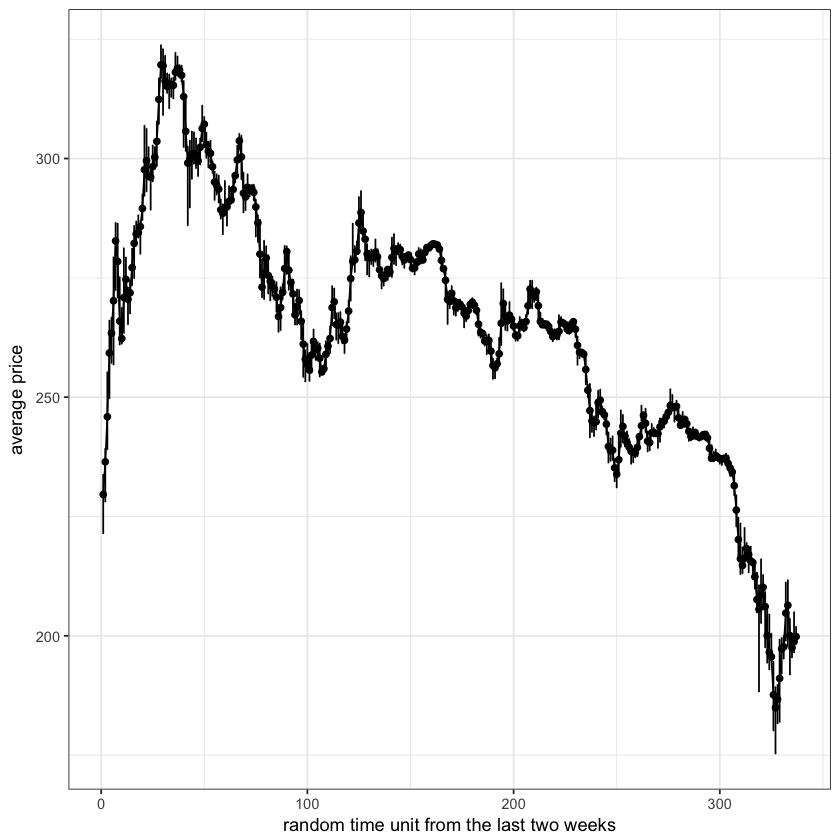

In [302]:
pd <- position_dodge(0.1) 
ggplot(data, aes(x=num, y=(open+close)/2), color = close-open) + 
    geom_errorbar(aes(ymin=low, ymax=high), width=.1, position=pd) +
    geom_line(position=pd) +
    geom_point(position=pd) + 
    scale_color_manual(values = c("red", "green")) + labs(y="average price", x="random time unit from the last two weeks") + theme_bw()

Adding missing grouping variables: `date`


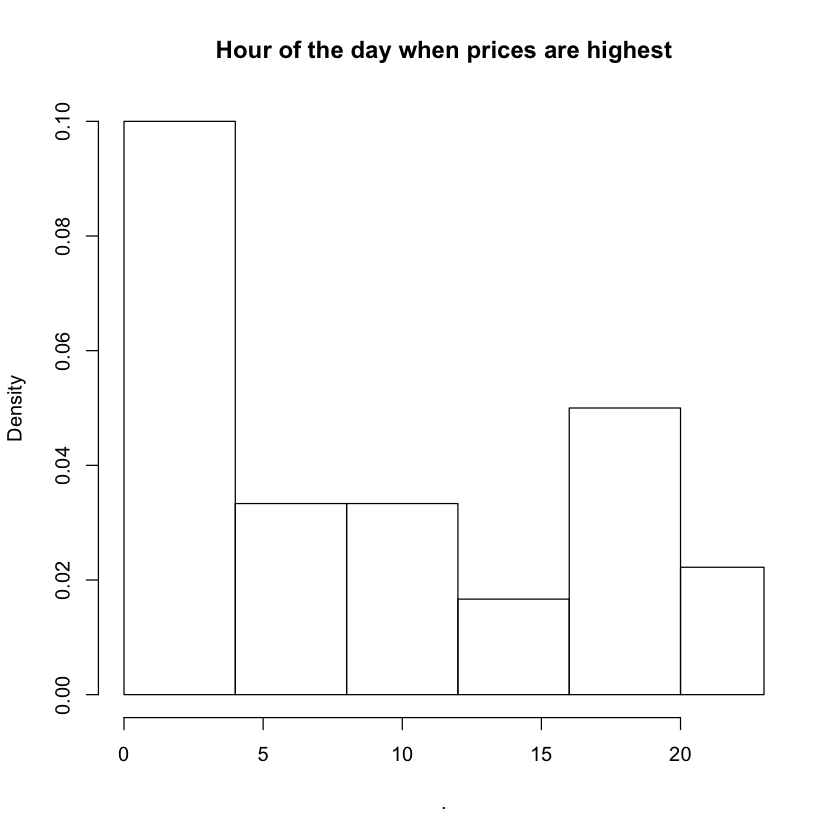

In [299]:
data %>% group_by(date) %>% top_n(1,high) %>% select(hour) %>% .$hour %>% hist(breaks=c(0,4,8,12,16,20,23), main="Hour of the day when prices are highest")

At what time of the day does the price deviate from the daily average the most (does not take into account daily trends, only the average)

In [65]:
#ggplot(
    data %>%
      # mutate(diff = close -open) %>% 
       group_by(date) %>% 
       mutate(dailyavg = mean(open)) %>% mutate(dailydev = open - dailyavg) %>% 
       group_by(hour) %>% summarize(meandailydev = mean(dailydev))
#    , aes(x=hour, y=meandailydev)) + geom_line()

hour,meandailydev
0,2.0059099
1,2.4351956
2,1.9866241
3,0.7959099
4,1.7601956
5,2.1437670
6,2.2816241
7,2.0466241
8,2.0909099
9,1.1066241


### Fit a linear model of the closing price, to the hour of the day for each day in the dataset

In [312]:
dfHour = data %>% group_by(date) %>%
  do(fitHour = lm(close ~ hour, data = .))

# get the coefficients by group in a tidy data_frame
dfHourCoef = tidy(dfHour, fitHour)
dfHourPred = augment(dfHour, fitHour)


head(dfHourPred)

date,close,hour,.fitted,.se.fit,.resid,.hat,.sigma,.cooksd,.std.resid
6/27/17,233.84,13,245.5950,6.851764,-11.7550000,0.31818182,11.85989,0.32049701642,-1.17198918
6/27/17,239.07,14,249.0493,5.905478,-9.9792727,0.23636364,12.23474,0.13678729641,-0.94013636
6/27/17,252.72,15,252.5035,5.048301,0.2164545,0.17272727,12.88344,0.00004007167,0.01959195
6/27/17,265.79,16,255.9578,4.333436,9.8321818,0.12727273,12.33466,0.05474173753,0.86645475
6/27/17,261.03,17,259.4121,3.841181,1.6179091,0.10000000,12.86959,0.00109512510,0.14040033
6/27/17,279.35,18,262.8664,3.662422,16.4836364,0.09090909,11.34151,0.10128362973,1.42326125


Add standardized residuals to original data frame

In [306]:
data$stdresidual = dfHourPred$.std.resid

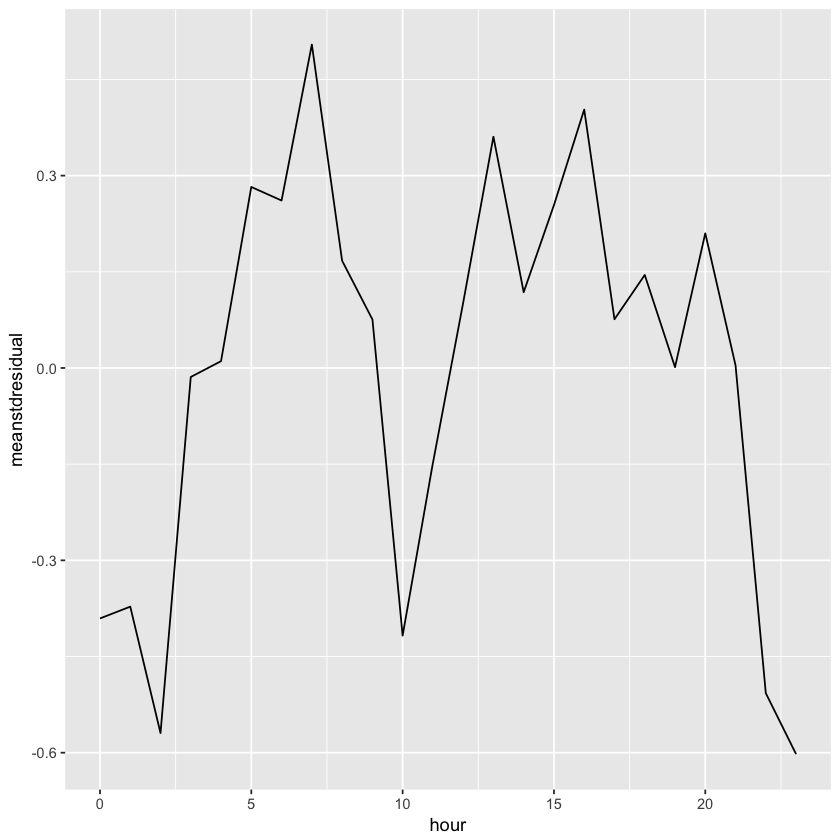

In [307]:
ggplot(data %>% group_by(hour) %>% summarize(meanstdresidual = mean(stdresidual))) + 
geom_line(aes(x=hour, y= meanstdresidual))

In [86]:
df = data %>% group_by(hour) %>% summarize(meanstdresidual = mean(stdresidual))

Add error bars to data

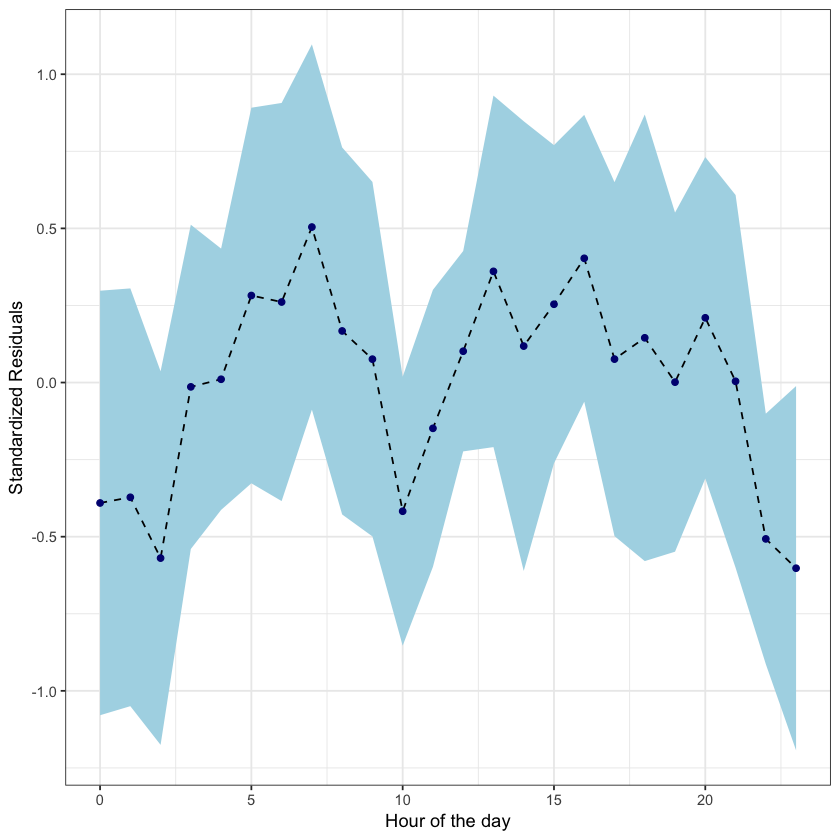

In [309]:
ggplot(data, aes(x=hour, y=stdresidual))+
    stat_summary(geom="ribbon", fun.data=mean_cl_normal, 
                 fun.args=list(conf.int=0.95), fill="lightblue")+
    stat_summary(geom="line", fun.y=mean, linetype="dashed")+
    stat_summary(geom="point", fun.y=mean, color="navy") + labs(x="Hour of the day", y="Standardized Residuals") + theme_bw()

# Analysis of bigger dataset from Dragos

Filtered to take every 10th row to reduce the size, also threw away some columns and added an "hour" column

In [2]:
dragosdata = read.csv("../data/mukund/every10th.csv", header=F, stringsAsFactors=F)

In [5]:
colnames(dragosdata) = c("datetime", "timestamp", "ethbid", "ethask", "btc", "exchange", "hour")

In [4]:
dragosdata = dragosdata[complete.cases(dragosdata),]

In [217]:
head(dragosdata)

,datetime,timestamp,ethbid,ethask,btc,exchange,hour
5,2017/5/29-12:59:1,1496077142,184.93,176.9999,2169.700,polo-b,12
6,2017/5/29-12:59:10,1496077151,184.93,177.0000,2168.100,polo-b,12
7,2017/5/29-12:59:16,1496077157,184.93,177.0000,2168.100,gdax-b,12
8,2017/5/29-12:59:25,1496077165,184.93,177.0000,2168.295,polo-p,12
9,2017/5/29-12:59:28,1496077169,184.93,177.0000,2160.660,polo-p,12
10,2017/5/29-12:59:36,1496077176,184.84,178.0000,2168.295,gdax-e,12


## Trading simulator 

### Start with 10 eth and $2000, sell every morning at 7 and buy at 10

In [11]:
eth = 10
cash = 2000
wallet = {}
wallet = c(wallet, 2000)
totaleth = {}
totaleth = c(totaleth, eth)
action = "buy"
ethprice = dragosdata$ethbid[1]
curdate = dragosdata$timestamp[1]

for (i in 1:nrow(dragosdata)){
    cash = wallet[length(wallet)] %>% as.numeric
    eth = totaleth[length(totaleth)] %>% as.numeric
    if (dragosdata$hour[i] %>% as.numeric == 7 && action=="sell" && eth >=10 && dragosdata$ethbid[i] > 100 ){
        eth = eth - 10
        cash = cash + 10*dragosdata$ethbid[i]
        action = "buy"
        wallet = c(wallet, cash)
        totaleth = c(totaleth, eth)
        ethprice = c(ethprice, dragosdata$ethbid[i])
        curdate = c(curdate,dragosdata$timestamp[i])

    }
    if (dragosdata$hour[i] %>% as.numeric == 10 && action == "buy" && cash >=10*dragosdata$ethbid[i] && dragosdata$ethbid[i]> 100){
        eth = eth + 10
        cash = cash - 10*dragosdata$ethbid[i]
        action= "sell"
        wallet = c(wallet, cash)
        totaleth = c(totaleth, eth)
        ethprice = c(ethprice, dragosdata$ethbid[i])
        curdate = c(curdate,dragosdata$timestamp[i])

    }
}


### Add networth for doing nothing, following my strategy and the difference between them

In [12]:
strat1 = data.frame(wallet, totaleth, ethprice, curdate)
strat1 = strat1 %>% mutate(mystrat = wallet+totaleth*ethprice)
strat1$donothing = strat1$ethprice*10+2000
strat1$diff = strat1$mystrat - strat1$donothin

### Difference in strategies

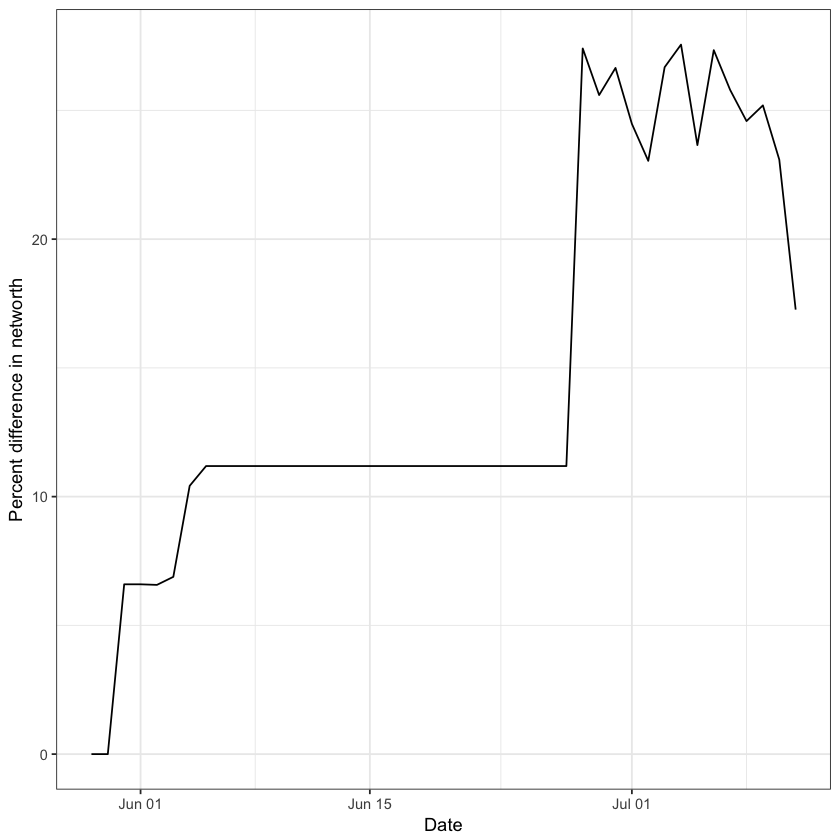

In [13]:
ggplot(strat1) + geom_line(aes(x=as.Date(as.POSIXct(curdate, origin="1970-01-01")), y=diff/40)) + 
labs(x="Date", y="Percent difference in networth") + theme_bw()

In [14]:
plotdf = strat1 %>% select(curdate, mystrat, donothing) %>% melt(id="curdate")
colnames(plotdf) = c("date", "strategy", "networth")


### RoI of strategies compared

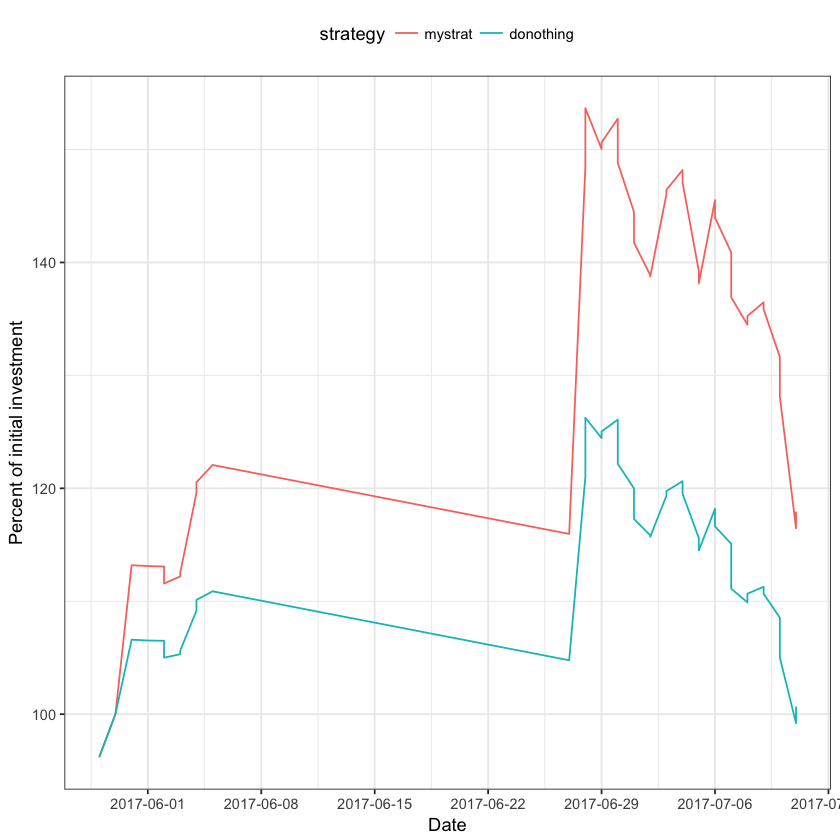

In [15]:
ggplot(plotdf) + geom_line(aes(x=as.Date(as.POSIXct(date, origin="1970-01-01")), y=networth/40, color = strategy)) + 
scale_x_date(date_breaks="7 days") + labs(x="Date", y="Percent of initial investment") + theme_bw() + 
theme(legend.position="top")